# Resolução do projeto de IC

## Grupo 1

In [10]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, visualize_transition
import matplotlib.pyplot as plt
import numpy as np

In [11]:
from qiskit.compiler import transpile

def execute_circuit_2(qc, shots=1024, decimal=False):
    #define backend
    device = Aer.get_backend('qasm_simulator')

    #get counts
    qc_transpiled = transpile(qc, backend=device)
    counts = device.run(qc_transpiled, shots=shots).result().get_counts()

    if decimal:
        counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
    else:
        counts = dict((a[::-1],b) for (a,b) in counts.items())

    return counts

In [12]:
def diffusion_operator_new(qr):
    qc = QuantumCircuit(qr)

    qc.h(qr)
    qc.x(qr)

    # Apply Hadamard gate to the last qubit.
    qc.h(qr[-1])
    qc.mct(qr[:-1], qr[-1])
    # Apply Hadamard gate to the last qubit.
    qc.h(qr[-1])

    qc.x(qr)
    qc.h(qr)

    return qc

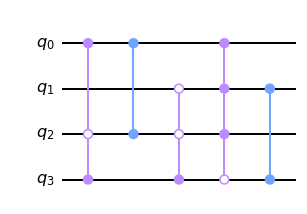

In [69]:
from qiskit.circuit.library import PhaseOracle
#oracle = PhaseOracle("(v0 | v1 | ~v2) & (~v0 | ~v1 | ~v2) & (~v0 | v1 | v2)")
#oracle = PhaseOracle("(v0 | ~v1 | ~v2) & (~v0 | ~v1 | v2) & (v0 | v1 | v2)")
#oracle = PhaseOracle("(v0 | v1 | v2)")
#oracle = PhaseOracle("(v0 | v1 | v2) & (~v0 | v1 | v2) & (v0 | ~v1 | ~v2) & (~v0 | v1 | ~v2) & (~v0 | ~v1 | ~v2)")
oracle = PhaseOracle.from_dimacs_file("3sat.dimacs")
oracle.draw(output='mpl')

In [70]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')


    genbin(bit_count)
    return binary_strings

generate_binary_strings(4)

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [71]:
def count_solutions(oracle_circ):
    k = 0
    for bstr in generate_binary_strings(oracle_circ.num_qubits):
        if oracle.evaluate_bitstring(bstr[::-1]):
            k += 1

    return k

In [72]:
for bstr in generate_binary_strings(4):
    print(f"evals to {oracle.evaluate_bitstring(bstr[::-1])} for: " + bstr)


evals to False for: 0000
evals to True for: 0001
evals to False for: 0010
evals to False for: 0011
evals to False for: 0100
evals to True for: 0101
evals to False for: 0110
evals to True for: 0111
evals to False for: 1000
evals to False for: 1001
evals to True for: 1010
evals to True for: 1011
evals to False for: 1100
evals to False for: 1101
evals to False for: 1110
evals to False for: 1111


In [73]:
count_solutions(oracle)

5

In [74]:
from math import sqrt, ceil, floor, pi

def my_grover(oracle_circ, iterations = 2):
    nqubits = oracle_circ.num_qubits

    qr = QuantumRegister(nqubits, 'q')
    cr = ClassicalRegister(nqubits, 'c')

    qc = QuantumCircuit(qr, cr)

    qc.h(qr)

    k = count_solutions(oracle_circ)
    N = 2**nqubits

    sqrtN = floor(pi/4 * sqrt(N/k))

    iterations=sqrtN
    for j in range(iterations):
        qc = qc.compose(oracle_circ)
        qc.barrier()
        qc = qc.compose(diffusion_operator_new(qr))

    qc.measure(qr, cr)
    return qc

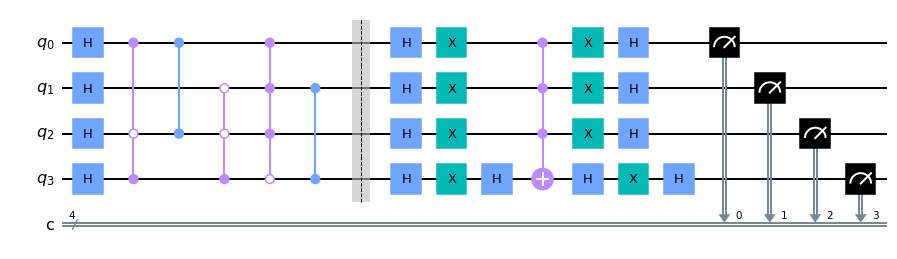

In [75]:
qc = my_grover(oracle)
qc.draw(output="mpl")

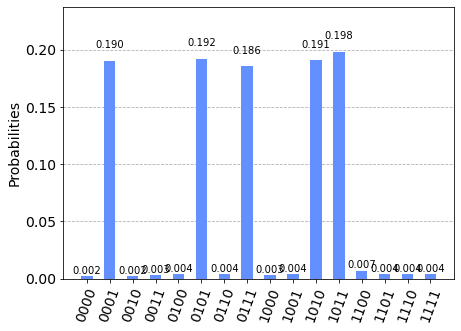

In [76]:
counts = execute_circuit_2(qc, shots = 4096)
plot_histogram(counts)